In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os

DATA_DIR = '/content/drive/My Drive/proto_data/'
PICKLED_DIR = os.path.join(DATA_DIR, 'pickled/')
#CONLLU_DIR = os.path.join(DATA_DIR, 'WSJ_conllus/')
#MODEL_DIR = '../saved_models/'

PROTO_TSV = os.path.join(DATA_DIR, 'protoroles_eng_pb_08302015.tsv')
#GLOVE_FILE = {'100': os.path.join(DATA_DIR, 'glove.6B.100d.txt') }

SPLITS = ['train', 'dev', 'test'] 

PROPERTIES = ['instigation', 'volition', 'awareness', 'sentient',
'exists_as_physical', 'existed_before', 'existed_during', 'existed_after',
'created', 'destroyed', 'predicate_changed_argument', 'change_of_state', 
'changes_possession', 'change_of_location', 'stationary', 'location_of_event', 
'makes_physical_contact', 'manipulated_by_another']

PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>'

weights_path = '/content/drive/My Drive/proto_data/weights.tch'


In [0]:
import sys
sys.path.insert(0, '/content/drive/My Drive/proto_modules')

In [6]:
from collections import defaultdict
import os
import pickle
from tqdm import tqdm
import random
import math

import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW, LBFGS
import scipy as sp

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device: ', device)

#import data_utils

device:  cuda:0


In [0]:
from torch import unsqueeze
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, \
        pack_padded_sequence, pad_sequence


class Attention(nn.Module):
  def __init__(self,
               n_properties=None,
               specific_size=None):
    super(Attention, self).__init__()

    self.n_properties = n_properties

    self.layer_norm = nn.LayerNorm(self.n_properties * specific_size)

  def forward(self, x):
    B = x.shape[0]

    x = x.view(B, self.n_properties, -1) # (B, n_props, size_specific)

    attn_scores = torch.bmm(x, torch.transpose(x, 2, 1)) # (B, n_props, n_props)
    dists = F.softmax(attn_scores, -1)
    attn_weighted_sum = torch.bmm(dists, x)

    x = x + attn_weighted_sum

    x = self.layer_norm(x.view(B, -1))

    return x


class SPRL(nn.Module):
    def __init__(self,
            vocab_size=None,
            emb_size=None,
            h_size=None,
            shared_size=None,
            padding_idx=None,
            emb_np=None,
            properties=None,
            use_attention=False,
            use_lstm=False,
            direction_feature=False,
            train_jointly=False,
            eye=False,
            updates_are_logits=False,
            sent_avg=False):
        super(SPRL, self).__init__()

        self.properties = properties
        self.n_properties = len(properties)
        self.direction_feature = direction_feature
        self.train_jointly = train_jointly

        self.word_emb = nn.Embedding(
                vocab_size,
                emb_size,
                padding_idx=padding_idx)
        self.word_emb.weight.data.copy_(torch.Tensor(emb_np))
        self.word_emb.weight.requires_grad = False


        self.lstm = None
        if use_lstm:
          self.use_lstm = True
          directions = 2
          if not train_jointly:
            self.lstm = {}
            for p in self.properties:
              self.lstm[p] = MyLSTM(
                emb_size=emb_size,
                h_size=h_size,
                directions=directions)
          else:
            self.lstm = MyLSTM(
                emb_size=emb_size,
                h_size=h_size,
                directions=directions)

          concatenated_embs_size = 2*(directions*h_size)
        
        else:
          concatenated_embs_size = (2*emb_size) + int(direction_feature)
          self.sent_avg = sent_avg
          if self.sent_avg:
            concatenated_embs_size += emb_size # While testing pred, head, and average sent embedding

        self.attention = None
        if not use_attention:
          shared_size = concatenated_embs_size
          #shared_size = self.n_properties
          self.shared = nn.Sequential(
              nn.Linear(concatenated_embs_size, shared_size, bias=True),
              nn.ReLU(),
              )
          self.prop_specific = nn.Sequential(
              nn.Linear(shared_size, self.n_properties, bias=True),
              )
          
          #self.clf = nn.Linear(self.n_properties*shared_size, self.n_properties, bias=True)
          #self.clf = nn.Linear(shared_size, self.n_properties, bias=True)
        else: # "shared" not really best name here...
          self.attention = True
          self.first_guess = nn.Sequential(
              nn.Linear(concatenated_embs_size, self.n_properties, bias=True),
              #nn.BatchNorm1d(self.n_properties, affine=False)
              #nn.ReLU()
              )
          
          self.updates_are_logits = updates_are_logits 
          
          self.updates = nn.Linear(self.n_properties, self.n_properties, bias=True)
          # self.updates = nn.Sequential(
          #     nn.Linear(self.n_properties, self.n_properties, bias=True),
          #     nn.ReLU(),
          #     nn.Linear(self.n_properties, self.n_properties, bias=True)
          #     )
          
          self.eye = eye
          if self.eye:
            self.updates.weight.data -= (torch.eye(self.n_properties) * self.updates.weight.data)


    def forward(self, sents, sent_lens, preds, heads, updates=True):

        # Sort the sentences so that the LSTM can process properly
        B, _, = sents.shape


        if self.lstm != None: # i.e., use lstm
          lens_sorted = sent_lens
          sents_sorted = sents
          indices = None
          if(len(sents) > 1):
              lens_sorted, indices = torch.sort(lens_sorted, descending=True)
              lens_sorted = lens_sorted.to(device)
              indices = indices.to(device)
              sents_sorted = sents_sorted.index_select(0, indices).to(device)
          w_embs = self.word_emb(sents_sorted)
          packed_lstm_input = pack_padded_sequence(
                  w_embs, lens_sorted, batch_first=True)

          # if type(self.lstm) == type(dict()):
          #   lstm_outs = {p: self.lstm[p](packed_lstm_input, indices) for p in self.properties}
          #   lstm_outs = torch.stack(list(lstm_outs.values()), dim=0).sum(0)
          lstm_outs = self.lstm(packed_lstm_input, indices)

          pred_reps = lstm_outs[np.arange(B), preds] # expecting (B, h_size)
          head_reps = lstm_outs[np.arange(B), heads] # same as above
        else: # no lstm, just MLP
          w_embs = self.word_emb(sents)
          pred_reps = w_embs[np.arange(B), preds] # expecting (B, h_size)
          head_reps = w_embs[np.arange(B), heads] # same as above
          if self.sent_avg:
            sent_avg = w_embs.mean(dim=1)

        if self.direction_feature:
          head_before_pred = torch.unsqueeze((preds > heads), -1).float() # (B,)
          pred_head_cat = torch.cat([pred_reps, head_reps, head_before_pred], dim=-1) # (B, 2*h_size)
          if self.sent_avg:
            pred_head_cat = torch.cat([pred_head_cat, sent_avg], dim=-1) # (B, 2*h_size)
        else:
          pred_head_cat = torch.cat([pred_reps, head_reps], dim=-1) # (B, 2*h_size)

        x = pred_head_cat
        if self.attention == None:
          x = pred_head_cat # Experimenting with having no shared and learned rep
          x = self.shared(x) # (B, size_shared) # For lstm

          logits = self.prop_specific(x)
        else:
          x = self.first_guess(x)
          if updates:
            if self.eye:
              self.updates.weight.data -= (torch.eye(self.n_properties).to(device) * self.updates.weight.data)
            x_up = self.updates(x) # 

            #logits = x + x_up # Residual model
            if self.updates_are_logits:
              logits = x_up
            else:
              logits = x + x_up # Residual model
          else:
            logits = x

        return logits

    def predict(self, logits):
        # That is to say, predict 0 if logit < 0 and 1 if logit >= 0
        predictions = (logits.sign() + 1) / 2

        return predictions


class MyLSTM(nn.Module):
    def __init__(self,
            emb_size=None,
            h_size=None,
            directions=None):
        super(MyLSTM, self).__init__()

        self.lstm = nn.LSTM(
                input_size=emb_size,    
                hidden_size=h_size,
                num_layers=1,
                bidirectional=(directions == 2),
                batch_first=True,
                dropout=0.,
                bias=True)
        
        self.lstm_drop = nn.Dropout(0.)

    def forward(self, packed_lstm_input, indices):
        outputs, _ = self.lstm(packed_lstm_input)
        outputs, _ = pad_packed_sequence(outputs, batch_first=True)

        # Unsort sentences to return to proper alignment with labels
        if len(outputs) > 1:
            outputs = unsort(outputs, indices)
          
        outputs = self.lstm_drop(outputs)

        return outputs

 
def unsort(batch, indices):
    indices_inverted = torch.argsort(indices)
    batch = batch.index_select(0, indices_inverted)
    return batch

In [0]:

def train(args, model, X, y):
    epochs = args['epochs']
    batch_size = args['batch_size']
    lr = args['lr']

    # Data loaders
    loader_train = data_loader(X['train'], y['train'],
            batch_size=batch_size, shuffle_idx=True)
    loader_dev = data_loader(X['dev'], y['dev'],
            batch_size=batch_size, shuffle_idx=False)
    n_train_batches = math.ceil(len(X['train']) / batch_size)
    n_dev_batches = math.ceil(len(X['dev']) / batch_size)
    
    #opt = AdamW(model.parameters(), lr=lr, betas=[0.9, 0.999])
    #opt = LBFGS(model.parameters())

    model, training_losses, dev_losses = train_loop(args, model, loader_train, loader_dev, n_train_batches, n_dev_batches)

    #model.load_state_dict(torch.load(weights_path))
    test_predictions = predictions = get_test_predictions(model, X['dev'], y['dev'])
    CI = bootstrap_conf_interval(test_predictions, y['dev'])

    print(f'\n Confidence interval : {CI}\n')

    fig, ax = plt.subplots(nrows=2, ncols=1)

    ax[0].plot(np.arange(len(training_losses)), np.array(training_losses), color='orange')
    ax[1].plot(np.arange(0, steps+1, n_train_batches), np.array(dev_losses), color='blue')
    fig.show()
    
    return


def train_loop(args, model, loader_train, loader_dev, n_train_batches, n_dev_batches):
    opt = Adam(model.parameters(), lr=lr, betas=[0.9, 0.999])

    for name, param in model.named_parameters():
      if 'updates' in name and 'weight' in name:
        original_weights = param.detach().clone()
    
    training_losses = []
    dev_losses = [4] # Meaningless first number, to avoid calculating dev loss before training
    steps = 0
    cma = 0 # cumulative moving average of training loss
    try:
      prev_best = 0.0
      for e in range(epochs):
        model.train()
        steps_ = 0
        for b in tqdm(
                range(n_train_batches), 
                ascii=True, 
                desc=f'Epoch {e+1}/{epochs} progress',
                position=0,
                leave=True,
                ncols=80):
          opt.zero_grad()
          sents, sent_lens, preds, heads, labels = next(loader_train)

          if args['use_attention']:
            stop_training_lower = e >= args['stop_training_lower']

            #step_updates = e > 0 or steps_ > (n_train_batches / 2)
            #if step_updates:
            if stop_training_lower:
              for p in model.parameters():
                p.requires_grad = False
              for p in model.updates.parameters():
                p.requires_grad = True
              
              logits = model(sents, sent_lens, preds, heads)
              # loss = bce_loss(logits, labels)
              # loss.backward()
              # opt.step()
              # opt.zero_grad()

            # Normal step
            if not stop_training_lower:
              for p in model.parameters():
                p.requires_grad = True
              for p in model.updates.parameters():
                p.requires_grad = False

                logits = model(sents, sent_lens, preds, heads, updates=False)
              # if b == n_train_batches - 1:
              #   print(logits[0])
          
          else: # Not attention
            logits = model(sents, sent_lens, preds, heads)

          loss = bce_loss(logits, labels)
          loss.backward()
          opt.step()
          steps_ += 1
          cma = (loss.item() + (steps_-1) * cma) / steps_
          training_losses.append(cma)
        # end of batch loop
        steps += steps_

        predictions = get_test_predictions(model, X['dev'], y['dev'])
        results, metrics = evaluate(args, predictions, y['dev'])
        F, precision, recall = metrics['F'], metrics['precision'], metrics['recall']
        #dev_losses.append(np.mean(dev_loss))
        dev_losses.append(-1)

        print(f"Epoch {e}, F={F*100:.2f}, p={precision*100:.2f}, r={recall*100:.2f}")

        if F > prev_best:
          prev_best = F
          torch.save(model.state_dict(), weights_path)

        if args['use_attention'] and args['show_weights'] and e >=5:
          for name, param in model.named_parameters():
            if 'updates' in name and 'weight' in name:
              updates_weights = param
          with torch.no_grad():
            show_weights((updates_weights - original_weights).cpu(), properties=model.properties)
            #show_weights((updates_weights).cpu(), properties=model.properties)
    except KeyboardInterrupt:
        pass
    # End of train loop

    model.load_state_dict(torch.load(weights_path)) # Get best weights back

    return model, training_losses, dev_losses


def show_weights(weights, properties=None, cmap='RdBu'):
    fig, ax = plt.subplots()

    norm = None
    if cmap == 'RdBu':
      vmax = weights.max()
      vmin = weights.min()
      if type(weights) == type(torch.randn(1)):
        vmax = vmax.item()
        vmin = vmin.item()
      norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)

    ax.set_xticks(np.arange(len(properties)))
    ax.set_yticks(np.arange(len(properties)))
    ax.set_xticklabels(properties)
    ax.set_yticklabels(properties)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode="anchor")

    if norm != None:
      plt.imshow(weights, cmap=cmap, norm=norm)
    else:
      plt.imshow(weights, cmap=cmap)
    cbar = plt.colorbar()

    return


def bce_loss(logits, labels):
    # Expected labels : (B, num_properties)
    loss = F.binary_cross_entropy_with_logits(logits, labels)
    return loss


def data_loader(X, y, batch_size=None, shuffle_idx=False):
    data = list(zip(X, y))
    idx = list(range(len(data)))
    while True:
        if shuffle_idx:
            random.shuffle(idx) # In-place shuffle
        
        for span in idx_spans(idx, batch_size):
            batch = [data[i] for i in span]
            yield prepare_batch(batch)


def idx_spans(idx, span_size):
    for i in range(0, len(idx), span_size):
        yield idx[i:i+span_size]


def prepare_batch(batch):
    # batch[i] = X, y
    batch_size = len(batch)
    sent_lens = torch.LongTensor([len(x[0][0]) for x in batch])
    max_length = torch.max(sent_lens).item()
    n_properties = len(batch[0][1])

    # Zero is padding index
    sents = torch.zeros((batch_size, max_length)).long().to(device)
    preds = torch.zeros(batch_size).long().to(device)
    heads = torch.zeros(batch_size).long().to(device)
    labels = torch.zeros(batch_size, n_properties).to(device)

    for i, (X_batch, y_batch) in enumerate(batch):
        sent, (pred_idx, head_idx) = X_batch
        sents[i,:len(sent)] = torch.LongTensor(sent)
        preds[i] = pred_idx
        heads[i] = head_idx
        labels[i] = torch.tensor(y_batch)

    return sents, sent_lens, preds, heads, labels


            #old dev eval code
          # with torch.no_grad():
          #   model.eval()
          #   tp = 0
          #   fp = 0
          #   fn = 0
          #   dev_loss = 0
          #   for b in tqdm(range(n_dev_batches), ascii=True, desc=f'Evaluating progress', ncols=80, position=0, leave=True):
          #     sents, sent_lens, preds, heads, labels = next(loader_dev)
          #     results_, metrics_, dev_loss_ = evaluate(args, model, sents, sent_lens, preds, heads, labels)
          #     tp += results_['tp']
          #     fp += results_['fp']
          #     fn += results_['fn']
          #     dev_loss += dev_loss_.item()

In [0]:
# def evaluate(args, model, sents, sent_lens, preds, heads, labels):
#     # Get predictions
#     logits = model(sents, sent_lens, preds, heads)
#     dev_loss = bce_loss(logits, labels)
#     predictions = model.predict(logits)

#     predictions, labels = predictions.cpu().numpy(), labels.cpu().numpy()
#     results, metrics = get_results_metrics(predictions, labels)

#     return results, metrics, dev_loss


def evaluate(args, predictions, labels):
    # Get predictions
    labels = np.array(labels)
    predictions, labels = predictions.cpu().numpy(), labels
    results, metrics = get_results_metrics(predictions, labels)

    return results, metrics


def get_results_metrics(predictions, labels):
    n_correct = (predictions == labels).astype(int).sum()

    # Precision, Recall
    eq = predictions == labels
    neq = predictions != labels

    pos_preds = predictions == 1
    neg_preds = predictions == 0

    tp = np.where(pos_preds, eq, 0).astype(int).sum()
    fp = np.where(pos_preds, neq, 0).astype(int).sum()
    fn = np.where(neg_preds, neq, 0).astype(int).sum()
    
    results = {
            'tp': tp,
            'fp': fp,
            'fn': fn
            }

    F, precision, recall = F_precision_recall(tp, fp, fn)
    metrics = {'F': F, 'precision': precision, 'recall': recall}

    return results, metrics


def F_precision_recall(tp, fp, fn):
    if tp + fp > 0.:
        precision = tp / (tp + fp)
    else:
        precision = 0.

    if tp + fn > 0.:
        recall = tp / (tp + fn)
    else:
        recall = 0.

    if precision + recall > 0.:
        F = (2 * precision * recall) / (precision + recall)
    else:
        F = 0.

    return F, precision, recall


def micro_average(results):
    tp, fp, fn = 0, 0, 0
    for v in results.values():
        tp += v['tp']
        fp += v['fp']
        fn += v['fn']
    
    return F_precision_recall(tp, fp, fn)


In [0]:
def get_data(args):
    df = pd.read_csv(PROTO_TSV, sep='\t')

    # Sentences
    sent_ids = set(df['Sentence.ID'].tolist())
    sents_path = os.path.join(PICKLED_DIR, 'sents.pkl')
    sents = None
    with open(sents_path, 'rb') as f:
      sents = pickle.load(f)

    # Dependency data
    # dependencies_path = os.path.join(PICKLED_DIR, 'dependencies.pkl')
    # with open(dependencies_path, 'rb') as f:
    #     deps, deps_just_tokens = pickle.load(f)  
    # sents['dependencies'] = deps
    # sents['deps_just_tokens'] = deps_just_tokens


    # Instances
    path = os.path.join(PICKLED_DIR, 'instances.pkl')
    proto_instances = None
    possible = None # Data to compare to SPRL paper
    with open(path, 'rb') as f:
      proto_instances, possible = pickle.load(f)

    # Word embedding data
    w2e = None
    path = os.path.join(PICKLED_DIR, f"glove_{args['glove_d']}.pkl")
    with open(path, 'rb') as f:
      w2e = pickle.load(f)

    w2i, i2w = None, None
    emb_np = None
    X, y = None, None
    dicts_path = os.path.join(PICKLED_DIR, 'dicts.pkl')
    with open(dicts_path, 'rb') as f:
        w2i, i2w = pickle.load(f)
    
    emb_np_path = os.path.join(PICKLED_DIR, 'emb_np.pkl')
    with open(emb_np_path, 'rb') as f:
        emb_np = pickle.load(f)
    
    lstm_data_path = os.path.join(PICKLED_DIR, 'lstm_data.pkl')
    with open(lstm_data_path, 'rb') as f:
        X, y = pickle.load(f)

    return {'df': df, 
            'proto_instances': proto_instances, 
            'possible': possible,
            'sents': sents,
            'w2e': w2e,
            'sent_ids': sent_ids,
            'lstm_data': (X,y),
            'dicts': (w2i, i2w),
            'emb_np': emb_np}


In [0]:
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return sp.ma.masked_array(sp.interp(value, x, y))

In [0]:
def bootstrap_conf_interval(predictions, labels, B=10000):
  predictions = predictions.cpu().numpy() # (n_test,18)
  N = predictions.shape[0]
  indices = np.arange(N)
  
  labels = np.array(labels)

  bs_samples = []
  for b in tqdm(range(B), desc='Getting bootstrap samples', ncols=80, position=0, leave=True):
    idx = np.random.choice(indices, N)
    curr_preds = predictions[idx]
    curr_labels = labels[idx]
    results, metrics = get_results_metrics(curr_preds, curr_labels)
    micro_f1 = metrics['F']
    bs_samples.append(micro_f1)

  plt.hist(bs_samples)
  
  return np.quantile(bs_samples, [0.025, 0.975])


In [0]:
def get_test_predictions(model, X_test, y_test, batch_size=100):

  loader_test = data_loader(X_test, y_test, batch_size=batch_size, shuffle_idx=False)

  n_batches = math.ceil(len(X_test) / batch_size)

  predictions = []
  with torch.no_grad():
    model.eval()
    for b in tqdm(range(n_batches), ascii=True, desc=f'Getting test predictions', ncols=80, position=0, leave=True):
      sents, sent_lens, preds, heads, _ = next(loader_test)
      logits = model(sents, sent_lens, preds, heads)
      predictions.append(model.predict(logits))
  
  predictions = torch.cat(predictions, dim=0)

  return predictions

In [0]:
def co_occurrences(y_train, normalize=False):
  n_props = y_train[0].shape[0]

  co_occur = np.zeros((n_props, n_props))
  anti_occur = np.zeros((n_props, n_props))
  both_negative = np.zeros((n_props, n_props))
  row_pos_col_neg = np.zeros((n_props, n_props))
  row_neg_col_pos = np.zeros((n_props, n_props))

  positive_counts = np.zeros(n_props)
  for labels in y_train:
    for i in range(n_props):
      if labels[i] == 1:
        positive_counts[i] += 1
        for j in range(i+1, n_props):
          if labels[j] == 1:
            co_occur[i,j] += 1

        for j in range(n_props):
          if labels[j] == 0:
            row_pos_col_neg[i,j] += 1
        
      else: # labels[i] == 0
        for j in range(i+1, n_props):
          if labels[j] == 0:
            both_negative[i,j] += 1
        
        for j in range(n_props):
          if labels[j] == 1:
            row_neg_col_pos[i,j] += 1
  
  negative_counts = len(y_train) - positive_counts

  # Mirror over diagonal
  co_occur = co_occur + np.transpose(co_occur)
  both_negative = both_negative + np.transpose(both_negative)
  #anti_occur = anti_occur + np.transpose(anti_occur)

  def normalize_rows(array):
    array /= np.sum(array, axis=-1, keepdims=True)

  positive_counts = np.expand_dims(positive_counts, axis=-1)

  # all_ = co_occur + both_negative + row_neg_col_pos + row_pos_col_neg
  # print(all_)
  # breakpoint()

  if normalize:
    #co_occur /= positive_counts
    # normalize_rows(co_occur)
    # #row_pos_col_neg /= positive_counts
    # normalize_rows(row_neg_col_pos)
    pass

  #normalizing_term = co_occur.sum()
  pij = co_occur / co_occur.sum()
  pi_ = pij.sum(-1)
  p_j = pij.sum(0)
  outer = pi_ * np.expand_dims(p_j, -1)
  for i in range(outer.shape[0]):
    outer[i][i] = 1
    pij[i][i] = 1
  #outer += np.eye(outer.shape[0])
  pmi = np.log(pij / outer)


  #print(f'Now max of anti_occur is {np.max(anti_occur)}, compared to {np.max(negative_counts)}')
  

  return co_occur, both_negative, row_pos_col_neg, row_neg_col_pos, pmi


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # This is added back by InteractiveShellApp.init_path()


NameError: ignored

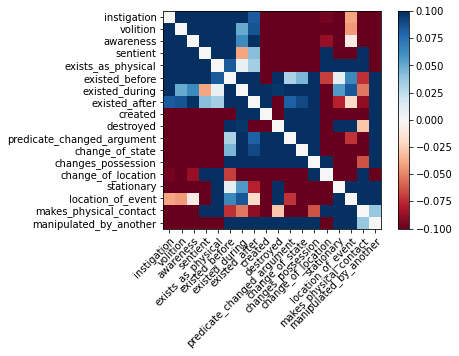

In [34]:
args = {
    'epochs': 10,
    'seed': 7,
    'lr': 1e-3,
    'batch_size': 100,
    'h_size': 100,
    #'shared_size': 300,
    'glove_d': 300,
    'use_attention': False,
    'use_lstm': False,
    'train_jointly': True, # Train the lstm jointly

    'show_weights': False,

    'stop_training_lower': 5,
    'eye':True,
    'updates_are_logits':False,

    'sent_avg':True
}

seed = args['seed']

random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

data = get_data(args)

w2i, i2w = data['dicts']
emb_np = data['emb_np']
X, y = data['lstm_data']

co_occur, both_negative, row_pos_col_neg, row_neg_col_pos, pmi = co_occurrences(y['train'], normalize=False)
show_weights(pmi, properties=PROPERTIES)
# show_weights(co_occur + both_negative, properties=PROPERTIES, cmap='Greens')
# show_weights(row_pos_col_neg + row_neg_col_pos, properties=PROPERTIES, cmap='Reds')
# show_weights((co_occur + both_negative) - (row_pos_col_neg + row_neg_col_pos), properties=PROPERTIES)
breakpoint()

model = SPRL(
    vocab_size=len(w2i),
    emb_size=int(args['glove_d']),
    h_size=args['h_size'],
    #shared_size=args['shared_size'],
    padding_idx=w2i[PAD_TOKEN],
    emb_np=emb_np,
    properties=PROPERTIES,
    use_attention=args['use_attention'],
    use_lstm=args['use_lstm'],
    direction_feature=not args['use_lstm'],
    train_jointly=args['train_jointly'],
    eye=args['eye'],
    updates_are_logits=args['updates_are_logits'],
    sent_avg=args['sent_avg'])
model.to(device)

train(args, model, X, y)